In [2]:
import warnings,sys,os
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import geohexgrid as ghg
import seaborn as sns
import shapely
from shapely import Point
import igraph as ig
from pathlib import Path
import matplotlib.pyplot as plt
import contextily as cx
import numpy as np
from matplotlib.colors import LinearSegmentedColormap,Normalize
from matplotlib.ticker import FuncFormatter, MultipleLocator
from matplotlib.patches import Rectangle,Patch
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import re
from exactextract import exact_extract
from matplotlib.lines import Line2D  # For custom legend
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as cx                                  
from simplify import *

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning) # exactextract gives a warning that is invalid

In [3]:
data_path = Path('input_files')
figure_path = Path('figures')

In [4]:
# =============================================================================
# 1. Load network and create graph
# =============================================================================
base_network = gpd.read_parquet(data_path / "base_network_SRB_basins.parquet")

edges = base_network.reindex(['from_id','to_id'] + [x for x in list(base_network.columns) if x not in ['from_id','to_id']], axis=1)
graph = ig.Graph.TupleList(edges.itertuples(index=False), edge_attrs=list(edges.columns)[2:], directed=True)
graph = graph.connected_components().giant()
edges = edges[edges['id'].isin(graph.es['id'])]

# =============================================================================
# 2. Load factory data
# =============================================================================
Path_FactoryFile = data_path / "2_Factory_Company_geolocations.xlsx"
DataFrame_Factory = pd.read_excel(Path_FactoryFile)

Clean_DataFrame_Factory = DataFrame_Factory.dropna(subset=["Latitude", "Longitude", "Factory"])

geometry = [Point(xy) for xy in zip(Clean_DataFrame_Factory["Longitude"], Clean_DataFrame_Factory["Latitude"])]

df_factories = gpd.GeoDataFrame(
    Clean_DataFrame_Factory[["Number"]].copy(),
    geometry=geometry,
    crs="EPSG:4326"
)

In [5]:
# =============================================================================
# 3. Create nodes from edges for spatial matching
# =============================================================================
vertex_lookup = dict(zip(pd.DataFrame(graph.vs['name'])[0], pd.DataFrame(graph.vs['name']).index))

tqdm.pandas()
from_id_geom = edges.geometry.progress_apply(lambda x: shapely.Point(x.coords[0]))
to_id_geom = edges.geometry.progress_apply(lambda x: shapely.Point(x.coords[-1]))

from_dict = dict(zip(edges['from_id'], from_id_geom))
to_dict = dict(zip(edges['to_id'], to_id_geom))

nodes = pd.concat([
    pd.DataFrame.from_dict(to_dict, orient='index', columns=['geometry']),
    pd.DataFrame.from_dict(from_dict, orient='index', columns=['geometry'])
]).drop_duplicates()

nodes['vertex_id'] = nodes.apply(lambda x: vertex_lookup[x.name], axis=1)
nodes = nodes.reset_index()

nodes_sindex = shapely.STRtree(nodes.geometry)

# =============================================================================
# 4. Map factories to nearest network nodes
# =============================================================================
df_factories['vertex_id'] = df_factories.geometry.progress_apply(
    lambda x: nodes.iloc[nodes_sindex.nearest(x)].vertex_id
).values

# =============================================================================
# 5. Load border crossings (Sinks)
# =============================================================================
path_to_Borders = data_path / "Borders_geocoded.xlsx"

Sink = pd.read_excel(path_to_Borders)
Sink = Sink.rename(columns={"LON": "Longitude", "LAT": "Latitude"})
Sink['geometry'] = Sink.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
Sink['vertex_id'] = Sink.geometry.apply(lambda x: nodes.iloc[nodes_sindex.nearest(x)].vertex_id).values



100%|██████████| 108/108 [00:00<?, ?it/s]


In [6]:
# =============================================================================
# 6. Calculate OD matrix and average access time
# =============================================================================
factory_vertices = df_factories['vertex_id'].unique()
sink_vertices = Sink['vertex_id'].unique()

OD_baseline = np.array(graph.distances(
    source=factory_vertices,
    target=sink_vertices,
    weights='fft'
))
OD_baseline[np.isinf(OD_baseline)] = 12

avg_time_per_factory = np.mean(OD_baseline, axis=1)
vertex_to_avg_time = dict(zip(factory_vertices, avg_time_per_factory))
df_factories['avg_access_time'] = df_factories['vertex_id'].map(vertex_to_avg_time)

print(f"Baseline average access time: {np.mean(OD_baseline):.2f} hours")

Baseline average access time: 3.65 hours


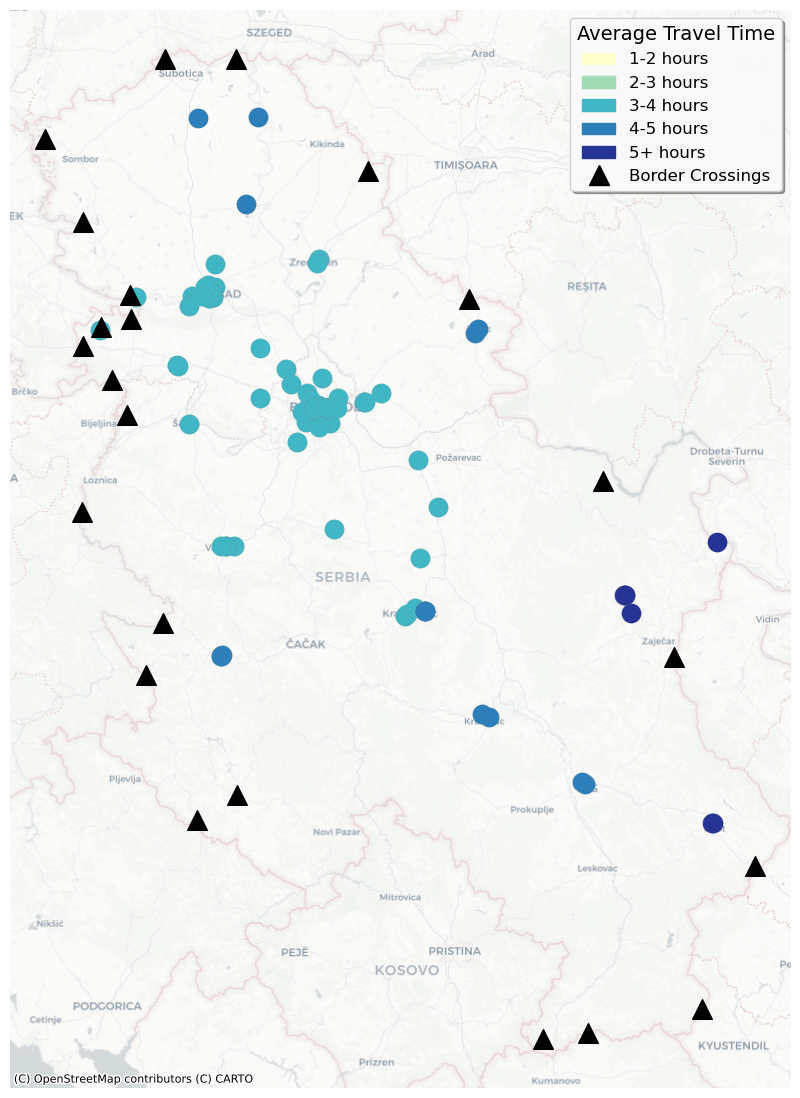

In [7]:
# =============================================================================
# 7. Visualization
# =============================================================================
df_factories_plot = df_factories.to_crs(3857)
Sink_plot = gpd.GeoDataFrame(Sink, geometry='geometry', crs="EPSG:4326").to_crs(3857)

bins = [1, 2, 3, 4, 5, float('inf')]
labels = ['1-2', '2-3', '3-4', '4-5', '5+']
colors = ['#ffffcc', '#a1dab4', '#41b6c4', '#2c7fb8', '#253494']

df_factories_plot['category'] = pd.cut(
    df_factories_plot['avg_access_time'], 
    bins=bins, labels=labels, right=False
)
df_factories_plot['category'] = df_factories_plot['category'].astype('object')
df_factories_plot.loc[df_factories_plot['category'].isna(), 'category'] = 'Not Accessible'

color_map = dict(zip(labels, colors))
color_map['Not Accessible'] = '#bdbdbd'

fig, ax = plt.subplots(figsize=(24, 14))

for category, color in color_map.items():
    data = df_factories_plot[df_factories_plot['category'] == category]
    if not data.empty:
        data.plot(ax=ax, color=color, legend=False, linewidth=0.1, edgecolor='grey', markersize=200)

Sink_plot.plot(ax=ax, color='black', markersize=200, marker='^')
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

ax.set_aspect('equal')
ax.axis('off')

legend_patches = [mpatches.Patch(color=color, label=f'{label} hours') 
                  for label, color in zip(labels, colors)]
legend_patches.append(Line2D([0], [0], marker='^', color='black', lw=0, 
                             label='Border Crossings', markersize=15))

ax.legend(handles=legend_patches, 
          loc='upper right',
          fontsize=12,
          title='Average Travel Time',
          title_fontsize=14,
          frameon=True,
          fancybox=True,
          shadow=True,
          framealpha=0.95)

plt.savefig(figure_path / 'factory_access_avg.png', dpi=200, bbox_inches='tight')
plt.show()

In [8]:
# =============================================================================
# 6b. Summary statistics
# =============================================================================
print("="*60)
print("BASELINE ACCESSIBILITY SUMMARY")
print("="*60)

# Basic stats
print(f"\nNumber of factories: {len(df_factories)}")
print(f"Number of border crossings: {len(Sink)}")
print(f"Number of OD pairs: {OD_baseline.size}")

print(f"\n--- Access Time Statistics (hours) ---")
print(f"Mean:   {df_factories['avg_access_time'].mean():.2f}")
print(f"Median: {df_factories['avg_access_time'].median():.2f}")
print(f"Std:    {df_factories['avg_access_time'].std():.2f}")
print(f"Min:    {df_factories['avg_access_time'].min():.2f}")
print(f"Max:    {df_factories['avg_access_time'].max():.2f}")

# Percentiles
print(f"\n--- Percentiles (hours) ---")
for p in [10, 25, 50, 75, 90, 95]:
    print(f"P{p}: {df_factories['avg_access_time'].quantile(p/100):.2f}")

# Category distribution
print(f"\n--- Factories by Access Time Category ---")
bins = [1, 2, 3, 4, 5, float('inf')]
labels = ['1-2', '2-3', '3-4', '4-5', '5+']
df_factories['category'] = pd.cut(df_factories['avg_access_time'], bins=bins, labels=labels, right=False)

category_counts = df_factories['category'].value_counts().sort_index()
for cat, count in category_counts.items():
    pct = count / len(df_factories) * 100
    print(f"  {cat}: {count} ({pct:.1f}%)")

# Unreachable pairs in OD matrix
n_unreachable = np.sum(OD_baseline == 12)
pct_unreachable = n_unreachable / OD_baseline.size * 100
print(f"\n--- Connectivity ---")
print(f"Unreachable OD pairs: {n_unreachable} ({pct_unreachable:.1f}%)")

BASELINE ACCESSIBILITY SUMMARY

Number of factories: 108
Number of border crossings: 23
Number of OD pairs: 1978

--- Access Time Statistics (hours) ---
Mean:   3.60
Median: 3.40
Std:    0.63
Min:    3.09
Max:    6.26

--- Percentiles (hours) ---
P10: 3.12
P25: 3.15
P50: 3.40
P75: 3.85
P90: 4.41
P95: 5.21

--- Factories by Access Time Category ---
  1-2: 0 (0.0%)
  2-3: 0 (0.0%)
  3-4: 86 (79.6%)
  4-5: 15 (13.9%)
  5+: 7 (6.5%)

--- Connectivity ---
Unreachable OD pairs: 0 (0.0%)
